<a href="https://colab.research.google.com/github/ElisabethShah/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_8_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## Setup

### Install dependencies

In [1]:
!pip install category_encoders eli5 pdpbox

### Import libraries

In [0]:
import category_encoders as ce
import eli5
import lightgbm as lgbm
import numpy as np
import pandas as pd
import pdpbox.pdp
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

### Define utility functions

In [0]:
def rmse(y_true, y_pred):
  """
  Calculate root mean squared error.
  """
  return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
  """
  Calculate root mean squared log error.
  """
  return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [0]:
def custom_scorer(estimator, X, y_true):
  """
  Return negative root mean squared log error (for maximization).
  """
  y_pred = estimator.predict(X)
  return -rmsle(y_true, y_pred)

### Load data

In [0]:
trainval = pd.read_csv('https://drive.google.com/uc?export=download'
                       '&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download'
                   '&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download'
                    '&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')

# Verify data dimensions.
assert trainval.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

## Split into training and validation sets

In [6]:
trainval['Store'].nunique()

100

In [0]:
train_stores, val_stores = train_test_split(trainval['Store'].unique(), 
                                            random_state=0)

In [8]:
train_stores.shape, val_stores.shape

((75,), (25,))

In [9]:
train = trainval[trainval['Store'].isin(train_stores)]
val = trainval[trainval['Store'].isin(val_stores)]

train.shape, val.shape

((58800, 7), (19600, 7))

## Data Exploration

#### Sales table

In [10]:
# Preview data.
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
4,34,5,2015-07-31,11144,1162,1,1
5,44,5,2015-07-31,6670,665,1,1
6,48,5,2015-07-31,3874,390,1,1


In [11]:
# Check data types.
train.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Promo             int64
SchoolHoliday     int64
dtype: object

In [12]:
# Examine summary statistics.
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
count,58800.000000,58800.000000,58800,58800.000000,58800.000000,58800.000000,58800.000000
unique,NaN,NaN,784,NaN,NaN,NaN,NaN
top,NaN,NaN,2014-05-26,NaN,NaN,NaN,NaN
freq,NaN,NaN,75,NaN,NaN,NaN,NaN
mean,557.226667,3.506378,NaN,7013.920357,825.035561,0.450255,0.195595
std,320.263225,1.710564,NaN,2849.244395,314.173058,0.497524,0.396662
min,4.000000,1.000000,NaN,1712.000000,208.000000,0.000000,0.000000
25%,270.000000,2.000000,NaN,4997.000000,600.000000,0.000000,0.000000
50%,551.000000,3.000000,NaN,6374.000000,759.000000,0.000000,0.000000
75%,839.000000,5.000000,NaN,8360.000000,989.000000,1.000000,0.000000


#### Store table

In [13]:
# Preview data.
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [14]:
# Check data types.
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [15]:
# Examine summary statistics.
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,200.000000,200,200,199.000000,163.000000,163.000000,200.000000,36.000000,36.000000,36
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,c,NaN,NaN,NaN,NaN,NaN,NaN,"Mar,Jun,Sept,Dec"
freq,NaN,127,112,NaN,NaN,NaN,NaN,NaN,NaN,14
mean,538.750000,NaN,NaN,4971.758794,7.319018,2010.748466,0.180000,23.916667,2011.666667,NaN
std,318.711977,NaN,NaN,7828.182796,3.165605,2.477911,0.385152,13.645250,0.956183,NaN
min,4.000000,NaN,NaN,30.000000,1.000000,2005.000000,0.000000,1.000000,2010.000000,NaN
25%,259.250000,NaN,NaN,890.000000,4.000000,2009.000000,0.000000,14.000000,2011.000000,NaN
50%,534.500000,NaN,NaN,2180.000000,9.000000,2011.000000,0.000000,22.000000,2012.000000,NaN
75%,819.500000,NaN,NaN,4655.000000,9.000000,2013.000000,0.000000,35.000000,2012.000000,NaN


In [16]:
# List possible promo2 schedules.
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

## 1. Wrangle relational data, log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

**Stretch goals**
- Engineer 3+ more features.

### Merge the `store` dataframe with the `train` and `test` dataframes

In [0]:
# Merge on shared column ("Store").
train = train.merge(store, how='left')
val = val.merge(store, how='left')
test = test.merge(store, how='left')

In [18]:
# Check output.
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,5,2015-07-31,13995,1498,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,5,2015-07-31,8492,833,1,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,34,5,2015-07-31,11144,1162,1,1,c,a,2240.0,9.0,2009.0,0,NaN,NaN,NaN
3,44,5,2015-07-31,6670,665,1,1,a,a,540.0,6.0,2011.0,0,NaN,NaN,NaN
4,48,5,2015-07-31,3874,390,1,1,a,a,1060.0,5.0,2012.0,0,NaN,NaN,NaN


### Arrange the X matrix and y vector for the train and test sets

In [0]:
target = 'Sales'

# Store number is a presumably meaningless identifier, and the goal is to 
# predict sales for unknown stores in any case. We probably don't want to fit 
# to it.
X_train = train.drop(columns='Store')
X_val = val.drop(columns='Store')
X_test = test.drop(columns='Store')

# Arrange X matrices.
X_train = X_train.drop(columns=target)
X_val = X_val.drop(columns=target)
X_test = X_test.drop(columns=target)

# Arrange y vectors.
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [20]:
# Check output.
X_train.head()

,DayOfWeek,Date,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,5,2015-07-31,1498,1,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,5,2015-07-31,833,1,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,5,2015-07-31,1162,1,1,c,a,2240.0,9.0,2009.0,0,NaN,NaN,NaN
3,5,2015-07-31,665,1,1,a,a,540.0,6.0,2011.0,0,NaN,NaN,NaN
4,5,2015-07-31,390,1,1,a,a,1060.0,5.0,2012.0,0,NaN,NaN,NaN


In [21]:
# Verify output dimensions.
X_train.shape

(58800, 14)

### Log-transform the target for the train and test set

In [0]:
# Take the natural log of the target variable.
y_train_log = np.log(y_train)
y_val_log = np.log(y_val)
y_test_log = np.log(y_test)

### Plot the target's distribution for the train set, before and after the transformation

#### Original target distribution

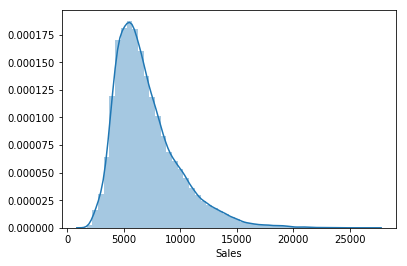

In [23]:
sns.distplot(y_train);

#### Log-transformed target distribution

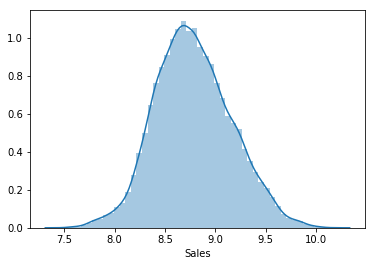

In [24]:
sns.distplot(y_train_log);

### Stretch: Engineer 3+ more features

#### Generate date-based features

In [0]:
def wrangle_dates(X):
  """
  Break date field into (numeric) component parts.
  """
  X = X.copy()
  
  X['Date'] = pd.to_datetime(X['Date'], infer_datetime_format=True)
  X['Year'] = X['Date'].dt.year
  X['Month'] = X['Date'].dt.month
  X['Week'] = X['Date'].dt.week
  X['DayOfMonth'] = X['Date'].dt.day
  X['DayOfWeek'] = X['Date'].dt.weekday
  
  return X

In [0]:
# Add date-based features to X matrices.
X_train_wrangled = wrangle_dates(X_train)
X_val_wrangled = wrangle_dates(X_val)
X_test_wrangled = wrangle_dates(X_test)

#### Add feature for place in promo 2 cycle

In [0]:
def add_Promo2Month(X):
  """
  Indicate place in promo 2 cycle:
  0 - first month
  1 - second month
  2 - final month
  """
  X = X.copy()
  
  promo2offset = pd.DataFrame([['Mar,Jun,Sept,Dec', 2], 
                               ['Jan,Apr,Jul,Oct', 0], 
                               ['Feb,May,Aug,Nov', 1]],
                              columns=['PromoInterval', 'Offset'])
  
  X = X.merge(promo2offset, how='left')
  X['Promo2Month'] = (X['Month'] - X['Offset'] - 1) % 3
  X = X.drop(columns='Offset')
  
  return X

In [0]:
# Add promo 2 month feature to X matrices.
X_train_wrangled = add_Promo2Month(X_train_wrangled)
X_val_wrangled = add_Promo2Month(X_val_wrangled)
X_test_wrangled = add_Promo2Month(X_test_wrangled)

In [29]:
# Check sample output.
X_train_wrangled[X_train_wrangled['Promo2']==1].sample(n=5, random_state=0)

,DayOfWeek,Date,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Week,DayOfMonth,Promo2Month
32986,1,2014-02-18,1338,1,0,c,c,2640.0,4.0,2011.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2014,2,8,18,2.0
29805,1,2014-04-08,962,0,0,a,a,250.0,9.0,2008.0,1,5.0,2013.0,"Feb,May,Aug,Nov",2014,4,15,8,2.0
33808,2,2014-02-05,1129,1,0,a,c,2840.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,2,6,5,1.0
18283,5,2014-10-11,809,0,0,a,c,2840.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,10,41,11,0.0
550,3,2015-07-23,836,0,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",2015,7,30,23,2.0


In [30]:
# Summarize wrangled data.
X_train_wrangled.describe(include='all')

,DayOfWeek,Date,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Week,DayOfMonth,Promo2Month
count,58800.000000,58800,58800.000000,58800.000000,58800.000000,58800,58800,58800.000000,50176.000000,50176.000000,58800.000000,7840.000000,7840.00000,7840,58800.000000,58800.000000,58800.000000,58800.000000,7840.000000
unique,NaN,784,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
top,NaN,2013-01-26 00:00:00,NaN,NaN,NaN,a,c,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct",NaN,NaN,NaN,NaN,NaN
freq,NaN,75,NaN,NaN,NaN,39200,34496,NaN,NaN,NaN,NaN,NaN,NaN,3920,NaN,NaN,NaN,NaN,NaN
first,NaN,2013-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.506378,NaN,825.035561,0.450255,0.195595,NaN,NaN,5678.800000,7.328125,2011.015625,0.133333,18.500000,2011.70000,NaN,2013.836735,5.961735,24.130102,15.817602,0.992347
std,1.710564,NaN,314.173058,0.497524,0.396662,NaN,NaN,10037.950729,3.010712,2.335164,0.339938,10.828895,1.10007,NaN,0.765245,3.346678,14.495580,8.703149,0.820358
min,0.000000,NaN,208.000000,0.000000,0.000000,NaN,NaN,30.000000,1.000000,2006.000000,0.000000,1.000000,2010.00000,NaN,2013.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,NaN,600.000000,0.000000,0.000000,NaN,NaN,1060.000000,4.750000,2009.750000,0.000000,14.000000,2011.00000,NaN,2013.000000,3.000000,12.000000,8.000000,0.000000


In [31]:
# Calculate and display correlation of numeric features with target variable.
X_train.select_dtypes(include='number').apply(lambda x: x.corr(y_train)).sort_values()

Promo2SinceYear             -0.300533
Promo2SinceWeek             -0.271295
DayOfWeek                   -0.210266
CompetitionDistance         -0.162567
CompetitionOpenSinceYear    -0.103999
CompetitionOpenSinceMonth    0.039571
SchoolHoliday                0.044972
Promo2                       0.069497
Promo                        0.361346
Customers                    0.898648
dtype: float64

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

### Begin with a baseline

#### RMSLE with original target

In [32]:
# Find mean of target variable.
y_train.mean()

7013.920357142857

In [33]:
# Calculate and print RMSLE.
y_train_pred_baseline = np.full_like(y_train, y_train.mean())
y_val_pred_baseline = np.full_like(y_val, y_train.mean())

print(f'Baseline training RMSLE: {rmsle(y_train, y_train_pred_baseline):.5f}')
print(f'Baseline validation RMSLE: {rmsle(y_val, y_val_pred_baseline):.5f}')

Baseline training RMSLE: 0.38722
Baseline validation RMSLE: 0.37664


#### RMSE with log-transformed target

In [34]:
# Find mean of log-transformed target.
y_train_log.mean()

8.7817773253162

In [35]:
# Calculate and predict RMSE.
y_train_pred_log_baseline = np.full_like(y_train_log, y_train_log.mean())
y_val_pred_log_baseline = np.full_like(y_val_log, y_train_log.mean())

print(f'Baseline training RMSE: {rmse(y_train_log, y_train_pred_log_baseline):.5f}')
print(f'Baseline validation RMSE: {rmse(y_val_log, y_val_pred_log_baseline):.5f}')

Baseline training RMSE: 0.38020
Baseline validation RMSE: 0.36741


### Try linear regression on numeric features

In [0]:
# Discard non-numeric features.
X_train_numeric = X_train_wrangled.select_dtypes(exclude=['object', 'datetime'])
X_val_numeric = X_val_wrangled.select_dtypes(exclude=['object', 'datetime'])
X_test_numeric = X_test_wrangled.select_dtypes(exclude=['object', 'datetime'])

In [37]:
# Check output dimensions.
X_train_numeric.shape

(58800, 15)

In [38]:
# List numeric features to be used.
X_train_numeric.columns

Index(['DayOfWeek', 'Customers', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Week', 'DayOfMonth',
       'Promo2Month'],
      dtype='object')

In [0]:
# Do a quick and dirty mean-based imputation.
imputer = SimpleImputer()

X_train_imputed = imputer.fit_transform(X_train_numeric)
X_val_imputed = imputer.transform(X_val_numeric)

In [40]:
# Generate and fit a linear regression model.
lr_model = LinearRegression()
lr_model.fit(X_train_imputed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Make predictions.
y_train_pred_linreg = lr_model.predict(X_train_imputed)
y_val_pred_linreg = lr_model.predict(X_val_imputed)

In [42]:
# Calculate and print RMSLE.
print(f'Linear regression training RMSLE: {rmsle(y_train, y_train_pred_linreg):.5f}')
print(f'Linear regression validation RMSLE: {rmsle(y_val, y_val_pred_linreg):.5f}')

Linear regression training RMSLE: 0.15238
Linear regression validation RMSLE: 0.19985


#### Permutation importances plot

In [43]:
# Generate and output permutation importances for linear regression model.
permuter = eli5.sklearn.PermutationImportance(lr_model, 
                                              scoring=custom_scorer, 
                                              cv='prefit', 
                                              n_iter=5, 
                                              random_state=0)

permuter.fit(X_val_imputed, y_val)
feature_names = X_val_numeric.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.3150 ± 0.0039,Customers
0.0199 ± 0.0004,Promo
0.0061 ± 0.0001,Promo2SinceYear
0.0049 ± 0.0006,CompetitionOpenSinceMonth
0.0039 ± 0.0003,Month
0.0017 ± 0.0003,Year
0.0012 ± 0.0001,CompetitionDistance
0.0011 ± 0.0001,Week
0.0003 ± 0.0001,Promo2SinceWeek
0.0002 ± 0.0001,Promo2Month


#### Re-run linear regression without `Customers` feature

This feature seems suspiciously like some kind of leakage. It's not something we'd expect to know in advance of opening a new location, certainly.

In [0]:
# Drop 'Customers' column from X matrix.
X_train_numeric_no_cust = X_train_numeric.drop(columns='Customers')
X_val_numeric_no_cust = X_val_numeric.drop(columns='Customers')
X_test_numeric_no_cust = X_test_numeric.drop(columns='Customers')

In [0]:
# Re-run imputation.
X_train_imputed_no_cust = imputer.fit_transform(X_train_numeric_no_cust)
X_val_imputed_no_cust = imputer.transform(X_val_numeric_no_cust)
X_test_imputed_no_cust = imputer.transform(X_test_numeric_no_cust)

In [46]:
# Re-fit model.
lr_model.fit(X_train_imputed_no_cust, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Make predictions.
y_train_pred_linreg_no_cust = lr_model.predict(X_train_imputed_no_cust)
y_val_pred_linreg_no_cust = lr_model.predict(X_val_imputed_no_cust)

In [48]:
# Calculate and print RMSLE.
print('Linear regression training RMSLE (no customer count):'
      f' {rmsle(y_train, y_train_pred_linreg_no_cust):.5f}')
print('Linear regression validation RMSLE (no customer count):'
      f' {rmsle(y_val, y_val_pred_linreg_no_cust):.5f}')

Linear regression training RMSLE (no customer count): 0.33727
Linear regression validation RMSLE (no customer count): 0.33525


#### Permutation importances plot (without `Customers` feature)

In [49]:
# Generate and output permutation importances for linear regression model 
# (without customer count feature).
permuter = eli5.sklearn.PermutationImportance(lr_model, 
                                              scoring=custom_scorer, 
                                              cv='prefit', 
                                              n_iter=5, 
                                              random_state=0)

permuter.fit(X_val_imputed_no_cust, y_val)
feature_names = X_val_numeric_no_cust.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0506 ± 0.0013,Promo
0.0083 ± 0.0004,CompetitionOpenSinceYear
0.0057 ± 0.0009,Month
0.0053 ± 0.0010,DayOfWeek
0.0047 ± 0.0002,Promo2
0.0042 ± 0.0004,Promo2SinceYear
0.0037 ± 0.0013,Promo2SinceWeek
0.0004 ± 0.0000,CompetitionOpenSinceMonth
0.0003 ± 0.0001,Year
0.0002 ± 0.0001,DayOfMonth


### Build random forest regressor

In [0]:
# Do ordinal encoding on categorical features.
encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train_wrangled.drop(columns='Customers'))
X_val_encoded = encoder.transform(X_val_wrangled.drop(columns='Customers'))

In [51]:
# Check output.
X_train_encoded.head()

,DayOfWeek,Date,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Week,DayOfMonth,Promo2Month
0,4,2015-07-31,1,1,1,1,620.0,9.0,2009.0,0,NaN,NaN,1,2015,7,31,31,NaN
1,4,2015-07-31,1,1,2,2,7520.0,10.0,2014.0,0,NaN,NaN,1,2015,7,31,31,NaN
2,4,2015-07-31,1,1,1,2,2240.0,9.0,2009.0,0,NaN,NaN,1,2015,7,31,31,NaN
3,4,2015-07-31,1,1,2,2,540.0,6.0,2011.0,0,NaN,NaN,1,2015,7,31,31,NaN
4,4,2015-07-31,1,1,2,2,1060.0,5.0,2012.0,0,NaN,NaN,1,2015,7,31,31,NaN


In [0]:
# Drop datetime columns.
X_train_encoded = X_train_encoded.select_dtypes(exclude='datetime')
X_val_encoded = X_val_encoded.select_dtypes(exclude='datetime')

In [0]:
# Fill null values with mean - note that this doesn't make a lot of sense in 
# many cases here, since the null values often mean "not applicable" rather 
# than "unknown", but we can come back to it later if time permits.
X_train_encoded_imputed = imputer.fit_transform(X_train_encoded)
X_val_encoded_imputed = imputer.transform(X_val_encoded)

In [0]:
# Generate and fit random forest regressor.
rf_model = RandomForestRegressor(n_estimators=10, 
                                 max_depth=4, 
                                 random_state=0).fit(X_train_encoded_imputed, 
                                                     y_train)

In [0]:
# Make predictions.
y_train_pred_rf = rf_model.predict(X_train_encoded_imputed)
y_val_pred_rf = rf_model.predict(X_val_encoded_imputed)

In [56]:
# Calculate and print RMSLE.
print(f'Random forest training RMSLE: {rmsle(y_train, y_train_pred_rf):.5f}')
print(f'Random forest validation RMSLE: {rmsle(y_val, y_val_pred_rf):.5f}')

Random forest training RMSLE: 0.30996
Random forest validation RMSLE: 0.32504


### Calculate test error for linear regression on numeric features

A more complex model doesn't seem to be making much difference, so let's return to this simpler (and less computationally intensive) option.

In [0]:
# Make predictions.
y_test_pred_linreg_no_cust = lr_model.predict(X_test_imputed_no_cust)

In [58]:
# Calculate and print RMSLE.
print('Linear regression test RMSLE (no customer count):'
      f' {rmsle(y_test, y_test_pred_linreg_no_cust):.5f}')

Linear regression test RMSLE (no customer count): 0.37047


### Stretch goal: optimize hyperparameters

In [59]:
# Set up pipeline.
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestRegressor(random_state=0)
)

# Recombine training and validation sets for cross-validation purposes.
groups = trainval['Store']
X_trainval = trainval.drop(columns=['Store', 'Sales', 'Customers'])
y_trainval_log = np.log(trainval['Sales'])

# Choose where to search. (Definite parameter space.)
param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 250), 
    'randomforestregressor__max_features': uniform(), 
    'randomforestregressor__min_samples_leaf':  [1, 10, 100]
}

# Search parameter space.
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_trainval, y_trainval_log, groups=groups);

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   32.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   32.2s finished


In [60]:
# Output results of hyperparameter optimization.
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'randomforestregressor__max_features': 0.87374613193801, 'randomforestregressor__min_samples_leaf': 100, 'randomforestregressor__n_estimators': 71}
Cross-validation RMSLE 0.34137009939756324


### Try gradient boosting

In [61]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    lgbm.sklearn.LGBMRegressor(learning_rate=0.2)
)

# Fit
pipeline.fit(X_train.drop(columns='Customers'), y_train)

# Validate
y_pred = pipeline.predict(X_val.drop(columns='Customers'))
print('Validation Error', rmsle(y_val, y_pred))

Validation Error 0.3615823521727281


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

### Permutation importances plots & stretch goals

See section 2, above.

### Partial dependency plot, 1 feature isolation

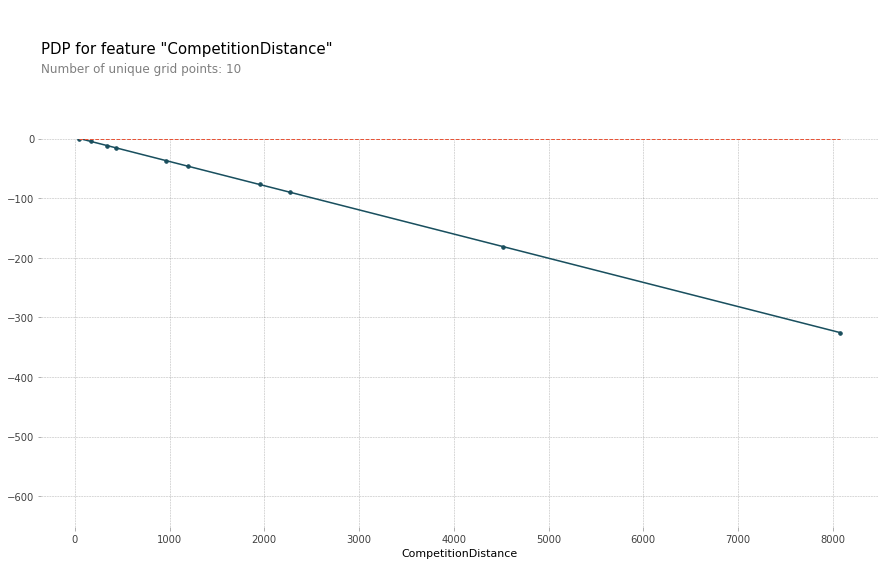

In [62]:
# Generate partial dependency isolation plot for 'CompetitionDistance' feature 
# of simple linear regression model.
feature = 'CompetitionDistance'

isolated = pdpbox.pdp.pdp_isolate(
    model=lr_model, 
    dataset=pd.DataFrame(X_val_imputed_no_cust, 
                         columns=X_val_numeric_no_cust.columns),
    model_features=X_val_numeric_no_cust.columns, 
    feature=feature
)

pdpbox.pdp.pdp_plot(isolated, feature_name=feature);

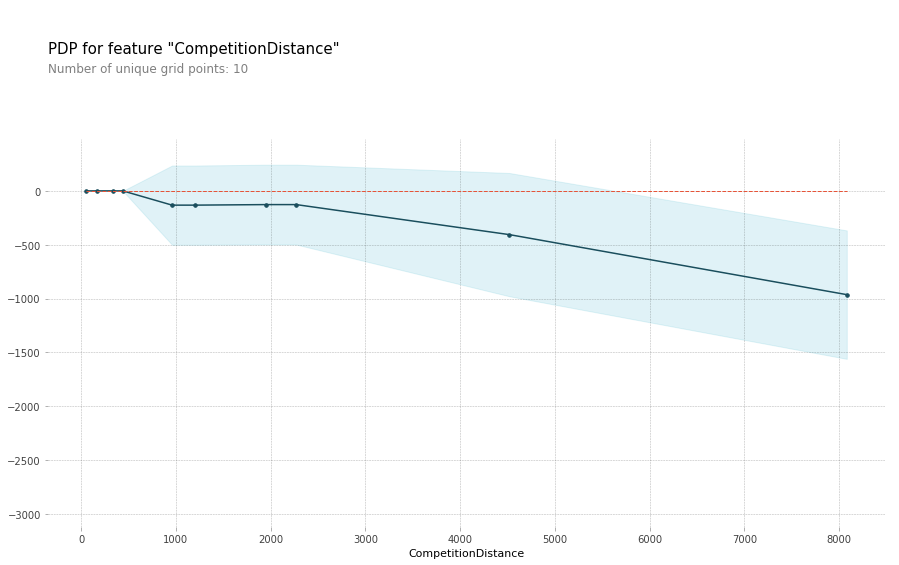

In [63]:
# Generate partial dependency isolation plot for 'Month' feature of random 
# forest regressor model.
feature = 'CompetitionDistance'

isolated = pdpbox.pdp.pdp_isolate(
    model=rf_model, 
    dataset=pd.DataFrame(X_val_encoded_imputed, 
                         columns=X_val_encoded.columns),
    model_features=X_val_encoded.columns, 
    feature=feature
)

pdpbox.pdp.pdp_plot(isolated, feature_name=feature);

### Partial dependency plot, 2-feature interaction

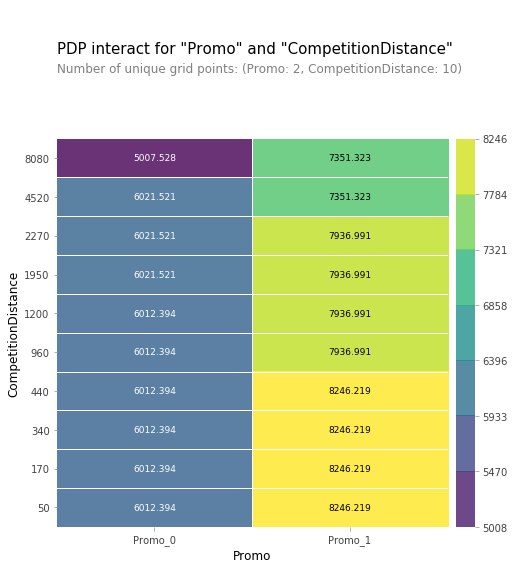

In [64]:
# Generate partial dependency interaction plot for 'Promo' and 
# 'CompetitionDistance' features of random forest regressor model.
features = ['Promo', 'CompetitionDistance']

interaction = pdpbox.pdp.pdp_interact(
    model=rf_model, 
    dataset=pd.DataFrame(X_val_encoded_imputed, 
                         columns=X_val_encoded.columns),
    model_features=X_val_encoded.columns, 
    features=features
)

pdpbox.pdp.pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

Our competition distance feature looks like it may be acting as a proxy variable for population density, given its apparently negative relationship with sales.